In [1]:
import pyfesom2 as pf
import xarray as xr
import os
import pandas as pd
from collections import OrderedDict
from itertools import product
import matplotlib.pylab as plt
import numpy as np
from matplotlib import cm
%matplotlib inline
import matplotlib.pylab as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

import tqdm as tqdm
from cdo import *   # python version
cdo = Cdo()
import csv
import cmocean as cmo
import dask
from dask.delayed import delayed
from dask.diagnostics import ProgressBar
import math


osgeo is not installed, conversion to Geo formats like Geotiff (fesom2GeoFormat) will not work.


In [67]:
# parameters cell
meshpath = '/p/project/chhb19/streffing1/input/fesom2/core2/'
remap_resolution = '360x180'
mesh_file = 'CORE2_finaltopo_mean.nc'
abg = [0, 0, 0]
variable = 'MLD2'
input_paths = ["/p/largedata/hhb19/jstreffi/runtime/awicm-3.1/PICT/outdata/fesom/"
               ]
input_names = ['PICT']

years = range(1850, 2015)

figsize=(6,4.5)
levels = [0, 3000, 11]
units = r'$^\circ$C'
columns = 2
dpi = 300
ofile = variable
region = "Global Ocean"

In [68]:
# Obtain input names from path if not set explicitly
if input_names is None:
    input_names = []
    for run in input_paths:
        run = os.path.join(run, '')
        input_names.append(run.split('/')[-2])

In [69]:
# Load fesom2 mesh
mesh = pf.load_mesh(meshpath, abg=abg, 
                    usepickle=True, usejoblib=False)

/p/project/chhb19/streffing1/input/fesom2/core2/pickle_mesh_py3_fesom2
The usepickle == True)
The pickle file for FESOM2 exists.
The mesh will be loaded from /p/project/chhb19/streffing1/input/fesom2/core2/pickle_mesh_py3_fesom2


In [70]:
# Set number of columns, in case of multiple variables
def define_rowscol(input_paths, columns=len(input_paths), reduce=0):
    number_paths = len(input_paths) - reduce
#     columns = columns
    if number_paths < columns:
        ncol = number_paths
    else:
        ncol = columns
    nrows = math.ceil(number_paths / columns)
    return [nrows, ncol]

In [86]:
# Load model Data
data_weddell = OrderedDict()
data_labrador = OrderedDict()

def load_parallel_weddell(variable,path,remap_resolution,meshpath,mesh_file):
    data1 = cdo.yearmean(input='-fldmean -sellonlatbox,-55,0,-78,-60 -setmissval,nan -setctomiss,0 -remap,r'+remap_resolution+','+meshpath+'/weights_unstr_2_r'+remap_resolution+'.nc -setgrid,'+meshpath+'/'+mesh_file+' '+str(path),returnArray=variable)
    return data1


def load_parallel_labrador(variable,path,remap_resolution,meshpath,mesh_file):
    data1 = cdo.yearmean(input='-fldmean -sellonlatbox,-52,-42,51,59 -setmissval,nan -setctomiss,0 -remap,r'+remap_resolution+','+meshpath+'/weights_unstr_2_r'+remap_resolution+'.nc -setgrid,'+meshpath+'/'+mesh_file+' '+str(path),returnArray=variable)
    return data1

for exp_path, exp_name  in zip(input_paths, input_names):

    datatw = []
    tw = []
    temporaryw = []
    datatl = []
    tl = []
    temporaryl = []
    for year in tqdm.tqdm(years):
        path = exp_path+'/'+variable+'.fesom.'+str(year)+'.nc'
        temporaryl = dask.delayed(load_parallel_labrador)(variable,path,remap_resolution,meshpath,mesh_file)
        temporaryw = dask.delayed(load_parallel_weddell)(variable,path,remap_resolution,meshpath,mesh_file)

        tl.append(temporaryl)
        tw.append(temporaryw)

    with ProgressBar():
        datatl = dask.compute(tl)
        datatw = dask.compute(tw)

    data_weddell[exp_name] = np.squeeze(datatw)
    data_labrador[exp_name] = np.squeeze(datatl)



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 165/165 [00:00<00:00, 11945.87it/s]

[                                        ] | 0% Completed |  0.1s

[########################################] | 100% Completed | 27.5s
[########################################] | 100% Completed | 27.7s


In [88]:
def smooth(x,beta):
    """ kaiser window smoothing """
    window_len=161
    beta=160
    # extending the data at beginning and at the end
    # to apply the window at the borders
    s = np.r_[x[window_len-1:0:-1],x,x[-1:-window_len:-1]]
    w = np.kaiser(window_len,beta)
    y = np.convolve(w/w.sum(),s,mode='valid')
    return y[80:len(y)-80]

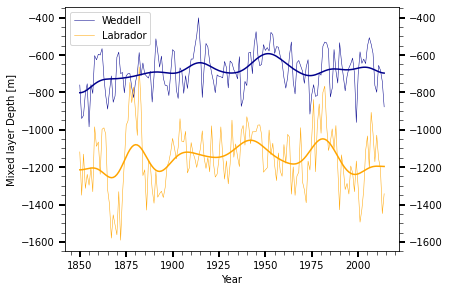

In [91]:
fig, ax = plt.subplots(figsize=figsize)

# plot raw data
for exp in input_names:
    
    plt.plot(years,data_weddell[exp],linewidth=0.5,color='darkblue')
    plt.plot(years,data_labrador[exp],linewidth=0.5,color='orange')

    plt.plot(years,smooth(data_weddell[exp],len(data_weddell[exp])),linewidth=1.5,color='darkblue')
    plt.plot(years,smooth(data_labrador[exp],len(data_labrador[exp])),linewidth=1.5,color='orange')


    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(which='minor', length=4)
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(which='minor', length=4)
    ax.tick_params(direction='out', length=6, width=2, grid_alpha=0.5,labelright=True)
    ax.yaxis.set_ticks_position('both')
    ax = plt.gca()
    plt.ylabel('Mixed layer Depth [m]')
    plt.xlabel('Year')
    ax.legend(['Weddell','Labrador'])
    
plt.savefig('Weddell_'+variable+'_timeseries.png', dpi=dpi,bbox_inches='tight')
